In [3]:
import numpy as np
import numpy.linalg as nla
import numpy.random as random
import scipy.linalg as la
import scipy.sparse as sp
from matplotlib import pyplot as plt
from itertools import product
import time
from tqdm import tqdm
from IPython.display import clear_output
from numpy import fft

In [7]:
# ------------------------------
# Wannier function constructor
# ------------------------------
def overcomplete_wannier_function(alpha, R, Nx, Ny):
    Rx, Ry = R

    # k-grids in radians per lattice spacing (FFT ordering)
    kx = 2*np.pi * np.fft.fftfreq(Nx, d=1.0)     # shape (Nx,)
    ky = 2*np.pi * np.fft.fftfreq(Ny, d=1.0)     # shape (Ny,)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')  # shape (Nx, Ny)

    # model vector n(k)
    nx = np.sin(KX)
    ny = np.sin(KY)
    nz = alpha - np.cos(KX) - np.cos(KY)
    nmag = np.sqrt(nx**2 + ny**2 + nz**2)
    nmag = np.where(nmag == 0, 1e-15, nmag)  # avoid divide-by-zero

    # --- Pauli matrices ---
    pauli_x = np.array([[0, 1], [1, 0]], dtype=complex)
    pauli_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    pauli_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # construct 2x2 identity (broadcasts over k-grid)
    Id = np.eye(2, dtype=complex)

    # construct k-space single-particle h(k) = n̂ · σ (unit vector)
    hk = (nx[..., None, None] * pauli_x +
          ny[..., None, None] * pauli_y +
          nz[..., None, None] * pauli_z) / nmag[..., None, None]  # (Nx,Ny,2,2)

    # construct upper and lower band projectors
    Pminus = 0.5 * (Id - hk)   # (Nx,Ny,2,2)
    Pplus  = 0.5 * (Id + hk)   # (Nx,Ny,2,2)

    # local choice of orbitals
    tauA = (1/np.sqrt(2)) * np.array([[1], [1]], dtype=complex)   # (2,1)
    tauB = (1/np.sqrt(2)) * np.array([[1], [-1]], dtype=complex)  # (2,1)

    # phase to shift center to R (Fourier shift theorem)
    phase_shift = np.exp(1j * (KX*Rx + KY*Ry))  # (Nx,Ny)

    # Helper: do FFT to real space
    fft2 = np.fft.fft2

    # ------------------------------
    # helper to build a normalized W
    # ------------------------------
    def make_W(Pband, tau, phase_shift, fft2, Nx, Ny):
        """
        psi_k = tau^† P(k), yielding shape (Nx, Ny, 2).
        """
        tau_dag = tau[:, 0].conj()                         # (2,)
        psi_k   = np.einsum('m,...mn->...n', tau_dag, Pband)  # (Nx,Ny,2)

        W = np.empty((Nx, Ny, 2), dtype=complex)
        W[:, :, 0] = fft2(phase_shift * psi_k[:, :, 0])
        W[:, :, 1] = fft2(phase_shift * psi_k[:, :, 1])

        norm = np.sqrt(np.vdot(W, W)) + 1e-15
        return W / norm

    # Build the four overcomplete Wannier spinors
    W_A_plus  = make_W(Pplus,  tauA, phase_shift, fft2, Nx, Ny)
    W_B_plus  = make_W(Pplus,  tauB, phase_shift, fft2, Nx, Ny)
    W_A_minus = make_W(Pminus, tauA, phase_shift, fft2, Nx, Ny)
    W_B_minus = make_W(Pminus, tauB, phase_shift, fft2, Nx, Ny)

    return W_A_plus, W_B_plus, W_A_minus, W_B_minus

In [8]:
# ------------------------------
# Pretty scatter-plotter (amp→size, phase→color)
# ------------------------------
def plot_wanniers(alpha=1.0, R=(0,0), Nx=41, Ny=41, size_max=450, gamma=0.8):
    (W_A_plus, W_B_plus, W_A_minus, W_B_minus) = overcomplete_wannier_function(alpha, R, Nx, Ny)

    xs = np.arange(Nx) - Nx//2
    ys = np.arange(Ny) - Ny//2
    X, Y = np.meshgrid(xs, ys, indexing='ij')

    fftshift = np.fft.fftshift

    panels = [
        (fftshift(W_A_minus[:, :, 0]), r'$W_{0,A,-}(\mathbf{r},1)$', 'a'),
        (fftshift(W_B_minus[:, :, 0]), r'$W_{0,B,-}(\mathbf{r},1)$', 'b'),
        (fftshift(W_A_plus [:, :, 0]), r'$W_{0,A,+}(\mathbf{r},1)$', 'c'),
        (fftshift(W_B_plus [:, :, 0]), r'$W_{0,B,+}(\mathbf{r},1)$', 'd'),
        (fftshift(W_A_minus[:, :, 1]), r'$W_{0,A,-}(\mathbf{r},2)$', 'e'),
        (fftshift(W_B_minus[:, :, 1]), r'$W_{0,B,-}(\mathbf{r},2)$', 'f'),
        (fftshift(W_A_plus [:, :, 1]), r'$W_{0,A,+}(\mathbf{r},2)$', 'g'),
        (fftshift(W_B_plus [:, :, 1]), r'$W_{0,B,+}(\mathbf{r},2)$', 'h'),
    ]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
    norm = plt.Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = plt.get_cmap('hsv')

    for ax, (W, title, letter) in zip(axes.flat, panels):
        amp = np.abs(W)
        amp /= amp.max() + 1e-12
        sizes = (amp**gamma) * size_max
        phase = np.angle(W)

        ax.scatter(X.ravel(), Y.ravel(), c=phase.ravel(), s=sizes.ravel(),
                   cmap=cmap, norm=norm, linewidths=0, alpha=0.95)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(title, fontsize=12)
        ax.text(0.04, 0.94, f'({letter})', transform=ax.transAxes,
                ha='left', va='top', fontsize=12)

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.9)
    cbar.set_label('Phase', fontsize=11)
    cbar.set_ticks([-np.pi, 0, np.pi])
    cbar.set_ticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    return fig, axes



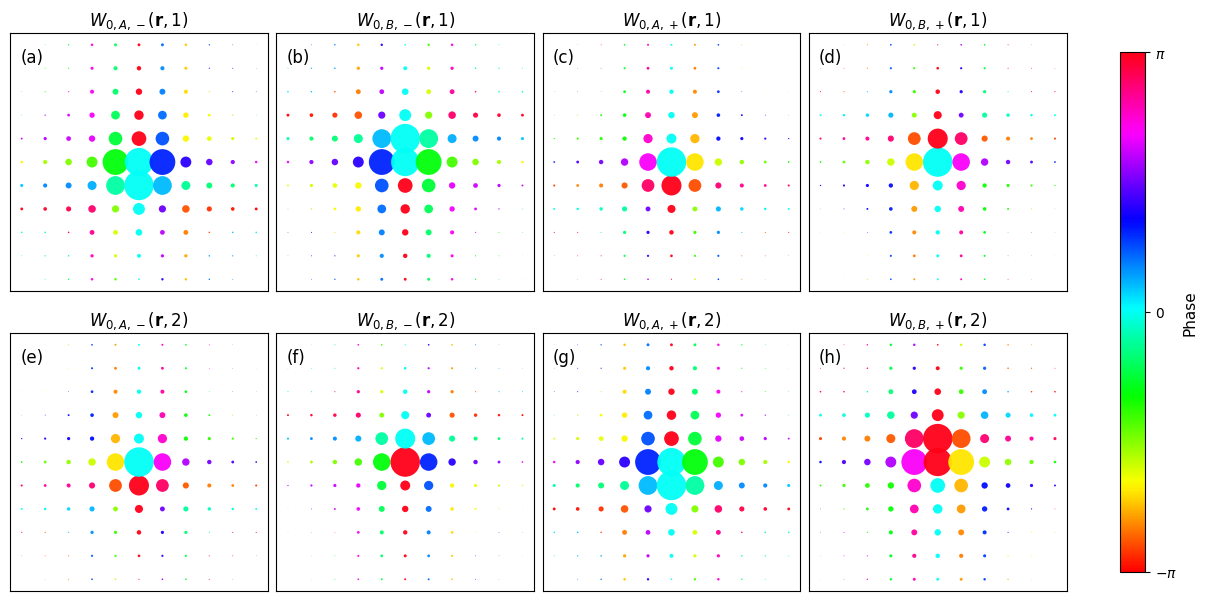

In [10]:
# Example run
plot_wanniers(alpha=1.0, R=(0,0), Nx=11, Ny=11)
plt.show()

In [23]:
def plot_wanniers_3d(alpha=1.0, R=(0,0), Nx=41, Ny=41, zscale='per-panel'):
    """
    8 separate 3D surfaces of probability density |W(r, mu)|^2
    zscale: 'per-panel' (normalize each to its max) or 'global' (same z scale)
    """
    W_A_plus, W_B_plus, W_A_minus, W_B_minus = overcomplete_wannier_function(alpha, R, Nx, Ny)

    # coordinate grid, centered
    xs = np.arange(Nx) - Nx//2
    ys = np.arange(Ny) - Ny//2
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    
    fftshift = np.fft.fftshift

    panels = [
        (fftshift(W_A_minus[:, :, 0]), r'$W_{0,A,-}(\mathbf{r},1)$', 'a'),
        (fftshift(W_B_minus[:, :, 0]), r'$W_{0,B,-}(\mathbf{r},1)$', 'b'),
        (fftshift(W_A_plus [:, :, 0]), r'$W_{0,A,+}(\mathbf{r},1)$', 'c'),
        (fftshift(W_B_plus [:, :, 0]), r'$W_{0,B,+}(\mathbf{r},1)$', 'd'),
        (fftshift(W_A_minus[:, :, 1]), r'$W_{0,A,-}(\mathbf{r},2)$', 'e'),
        (fftshift(W_B_minus[:, :, 1]), r'$W_{0,B,-}(\mathbf{r},2)$', 'f'),
        (fftshift(W_A_plus [:, :, 1]), r'$W_{0,A,+}(\mathbf{r},2)$', 'g'),
        (fftshift(W_B_plus [:, :, 1]), r'$W_{0,B,+}(\mathbf{r},2)$', 'h'),
    ]

    # compute all |W|^2 first (for optional global scaling)
    Zs = [np.abs(Wc)**2 for (Wc, _, _) in panels]
    if zscale == 'global':
        zmax = max(Z.max() for Z in Zs) + 1e-15
    else:
        zmax = None

    figs_axes = []
    for (Z, (_, title, letter)) in zip(Zs, panels):
        # per-panel normalization (nice shape contrast),
        # or keep global scale to compare absolute magnitudes
        if zscale == 'per-panel':
            Zplot = Z / (Z.max() + 1e-15)
        else:
            Zplot = Z / zmax

        fig = plt.figure(figsize=(5.2, 4.2))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Zplot, rstride=1, cstride=1,
                               cmap='viridis', linewidth=0, antialiased=True)

        ax.set_title(title + f"   ({letter})", fontsize=12)
        ax.set_xlabel(r'$x$'); ax.set_ylabel(r'$y$'); ax.set_zlabel(r'$|W|^2$')
        ax.set_box_aspect((1, 1, 0.6))  # nicer aspect
        fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.1, label=r'$|W|^2$')

        figs_axes.append((fig, ax))

    return figs_axes

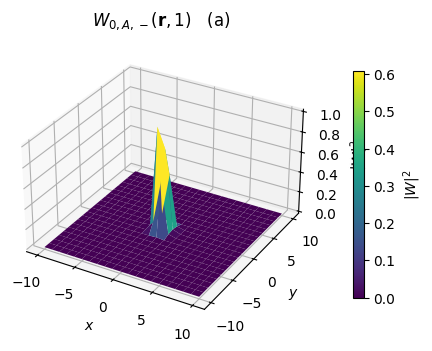

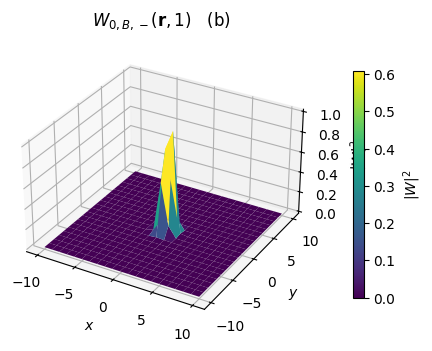

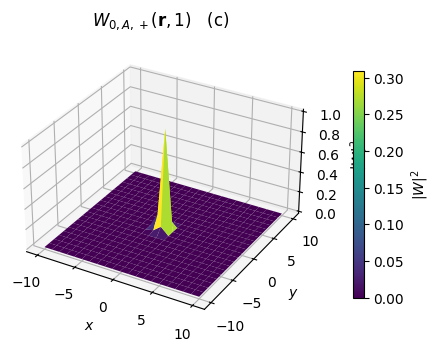

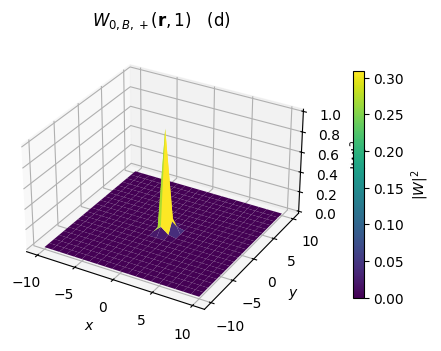

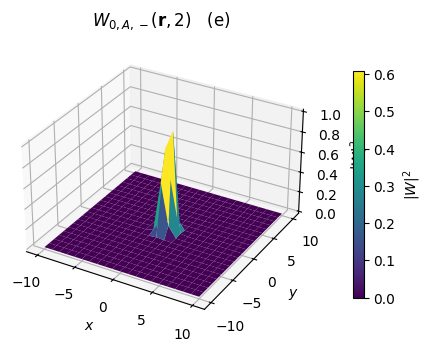

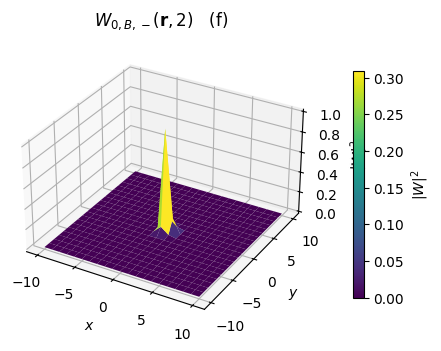

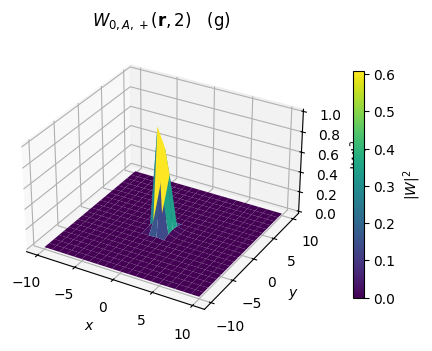

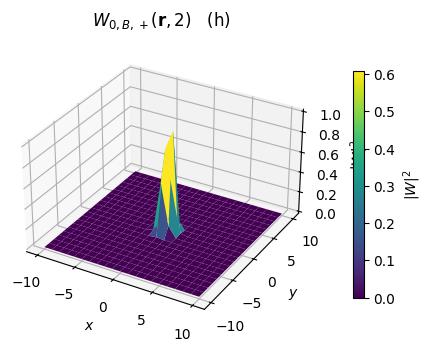

In [24]:
# Example:
fa = plot_wanniers_3d(alpha=1.0, R=(0,0), Nx=21, Ny=21, zscale='per-panel')
plt.show()